In [2]:
import os
import numpy as np
import pandas as pd
import scipy
import anndata
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt

In [277]:
cwd = os.getcwd()
adata = sc.read_h5ad(cwd+'/outs/AY_240828_kinker_anndata.h5ad')

In [278]:
# Plot subset of list of representative pool of cell line assignments.
# Lung:  NCIH1048, NCIH1568, NCIH1792, NCIH1944, NCIH2077, NCIH2087, NCIH358, NCIH727
# Breast: EFM192A, HCC1419, KPL1, ZR751
# Pancreatic: PANC0203, PK45H, SW1990
# Esoph: KYSE520, TE6
# Sarcoma: HS729, RD
# colon: CL34
# endo.: HEC59
# renal: KMRC3
# head_and_neck: SNU423
# gastric: MKN7

# Make new columns in adata called CellLine_Id, CellType
# adata.obs['CellLine_Id']=adata.obs['CellLine'].str.split('_').str[0]

# adata.obs['CellType']=adata.obs['CellLine'].str.split('_').str[1]+'_'+adata.obs['CellLine'].str.split('_').str[2]

# Split 'CellLine' into two parts
adata.obs[['CellLine_Id', 'CellType']] = adata.obs['CellLine'].str.split('_', n=1, expand=True)

print(subset_adata.obs[['CellLine', 'CellLine_Id', 'CellType']].tail())


                                    CellLine CellLine_Id         CellType
TTTGTCACATGGTCTA-12-10     PANC0203_PANCREAS    PANC0203         PANCREAS
TTTGTCAGTAGTAGTA-12-10  CL34_LARGE_INTESTINE        CL34  LARGE_INTESTINE
TTTGTCAGTCCGAATT-12-10         NCIH1568_LUNG    NCIH1568             LUNG
TTTGTCAGTCGGCTCA-12-10          MKN7_STOMACH        MKN7          STOMACH
TTTGTCAGTTGTCGCG-12-10         NCIH1944_LUNG    NCIH1944             LUNG


In [281]:
# see if there's 'CAK12' in dataset:
fig2b_list = ['CAK12']
cak12 = adata[adata.obs['CellLine_Id'].isin(fig2b_list)]
print(cak12.obs.head())

Empty DataFrame
Columns: [CellLine, Pool, Indication, Genes_expressed, Discrete_cluster_minpts5_eps1.8, Discrete_cluster_minpts5_eps1.5, Discrete_cluster_minpts5_eps1.2, CNA_subclone, SkinPig_score, EMTI_score, EMTII_score, EMTIII_score, IFNResp_score, p53Sen_score, EpiSen_score, StressResp_score, ProtMatu_score, ProtDegra_score, G1/S_score, G2/M_score, n_genes, CellLine_Id, CellType]
Index: []

[0 rows x 23 columns]


In [137]:
# select only rows where 'CellLine_ID' are in the following list:
selected_cell_lines=['NCIH1048', 'NCIH1568', 'NCIH1792', 'NCIH1944', 'NCIH2077', 'NCIH2087', 'NCIH358', 'NCIH727', 
                     'EFM192A', 'HCC1419', 'KPL1', 'ZR751',
                     'PANC0203', 'PK45H', 'SW1990',
                     'KYSE520', 'TE6', 'HS729', 'RD', 'CL34', 'HEC59', 'KMRC3', 'SNU423', 'MKN7']

# Filter the adata object to include only those that belong in the above list:
subset_adata = adata[adata.obs['CellLine_Id'].isin(selected_cell_lines), :]


In [262]:
# function to preprocess annotated dataframe
def BasicScanpyPreprocessing(adata, n_top_genes=2000, n_neighbors=10, n_pcs=40, random_state=20):
    # normalizes the total counts per cell to 10000 target_sum.  
        # it scales the total expression for each cell so that each cell has the same total count, 
        # which corrects for differences in sequencing depth between cells.
    sc.pp.normalize_total(adata, target_sum=1e4)

    # logarithmize the data.  This log-transforms the data to reduce the skewness of the data and makes it more normally distributed.
    sc.pp.log1p(adata)

    # Identify highly variable genes using the method that the "Seurat" software uses, filter out the low variance genes that may be less informative.
    sc.pp.highly_variable_genes(adata, n_top_genes=n_top_genes, flavor='seurat')
    
    # sc.pp.scale(adata, max_value=10)

    # Reduces the dimentionality of the data by using the Principal Component Analysis. This captures the most significant variations in the data with fewer dimensions, making it easier to analyze.
    sc.tl.pca(adata, svd_solver='arpack')

    # Neighbor Graph construction based on the PCA results.  
        # It identifies the nearest neighbors of each cell in the reduced PCA space using the specified number of neighbors.  
        # The number of PCs to use determines how many principal components are considered when calculating the neighbor graph.
        # The 'random_state` parameter ensures reproducibility.
    sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=n_pcs, random_state=random_state)

    # UMAP (Uniform Manifold Approximation and Projection).  Generate a UMAP to visualize the data.
        # UMAP is a dimensionality reduction technique that is particularly good at preserving the global structure of the data while also capturing local neighborhoods.
        # It projects the high-dimensional data into 2D or 3D space, which is helpful for visualizing clusters of cells.
    sc.tl.umap(adata, random_state=random_state)

    # Leiden Clustering of cells into groups
        # The Leiden algorithm is a community detection method, which is used to identify clusters of similar cells based on the neighbor graph.
        # The 'random_state` parameter ensures reproducibility of the clustering results.
    sc.tl.leiden(adata, random_state=random_state, flavor="igraph", n_iterations=2)

    # Run t-SNE. Use sc.tl.tsne function to calculate the t-SNE embedding.
    sc.tl.tsne(adata, perplexity=30, n_pcs=n_pcs)  # use the first 40 principal components

    return adata

In [229]:
adata = BasicScanpyPreprocessing(adata, n_top_genes=2000, n_neighbors=10, n_pcs=40, random_state=20)

In [139]:
subset_adata = BasicScanpyPreprocessing(subset_adata, n_top_genes=2000, n_neighbors=10, n_pcs=40, random_state=20)

/Users/weihsienyang/Library/Python/3.9/lib/python/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


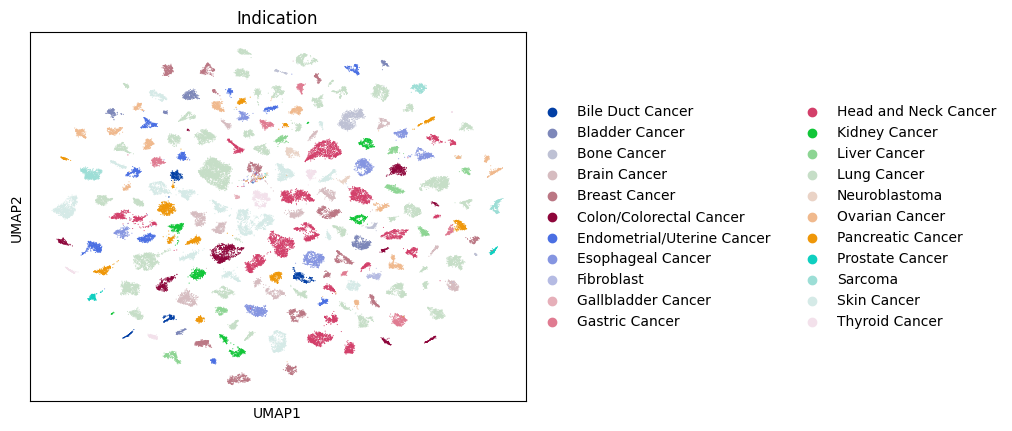

In [37]:
# Plot UMAP using full dataset.
sc.pl.umap(adata, color=['Indication'])

**There are several differences between the Kinker paper's Fig 1b and the plot produced above.**

- The Kinker paper uses a t-SNE plot rather than UMAP.  
- This plot shows a lot more clusters than the Kinker plot.  
- This plot is also colored by Indication rather than by CellLine. 
- The Kinker paper shows a representative subset of cell line assignments rather than all the data. 


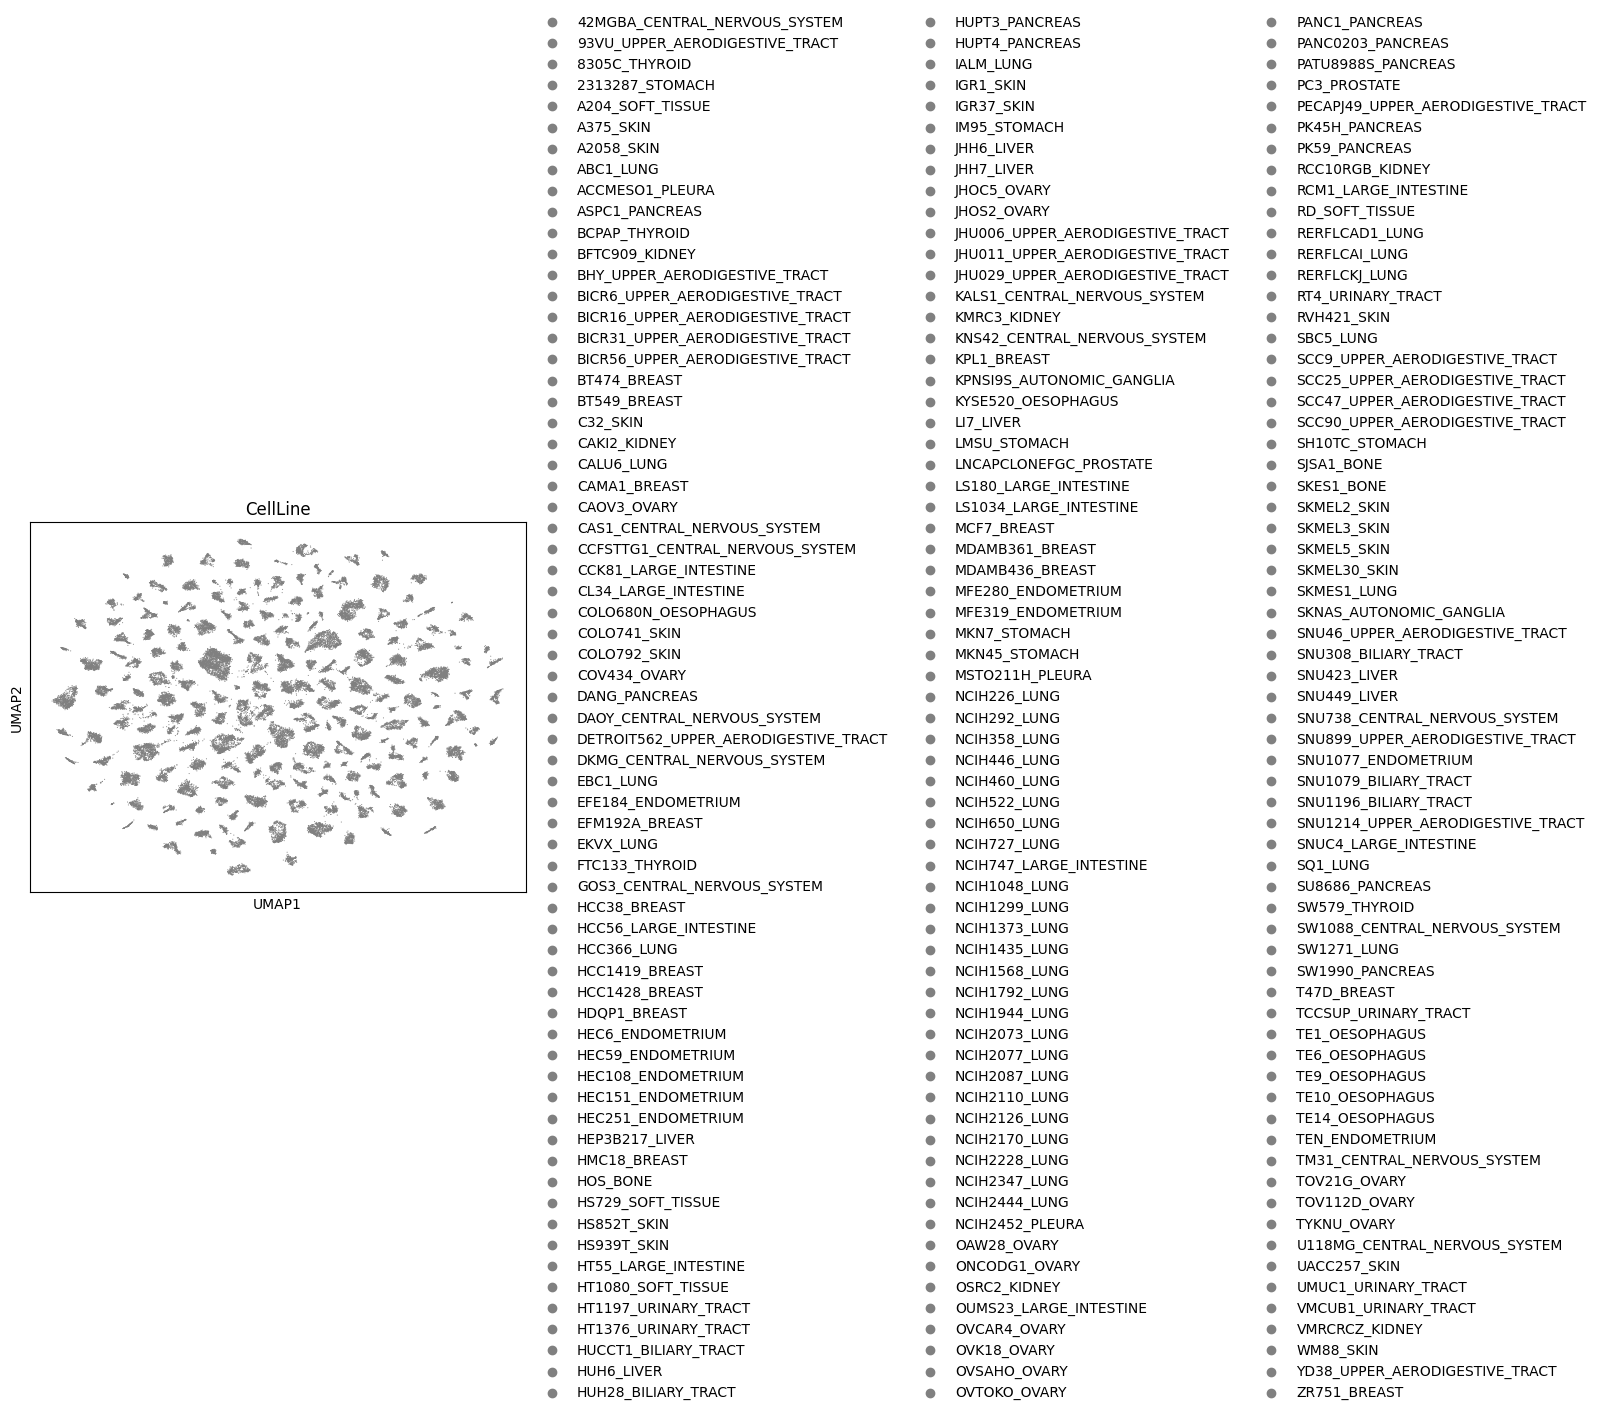

In [38]:
# Try to plot UMAP by different columns of the metadata.
# sc.pl.umap(adata, color=['Genes_expressed'])
sc.pl.umap(adata, color=['CellLine'])

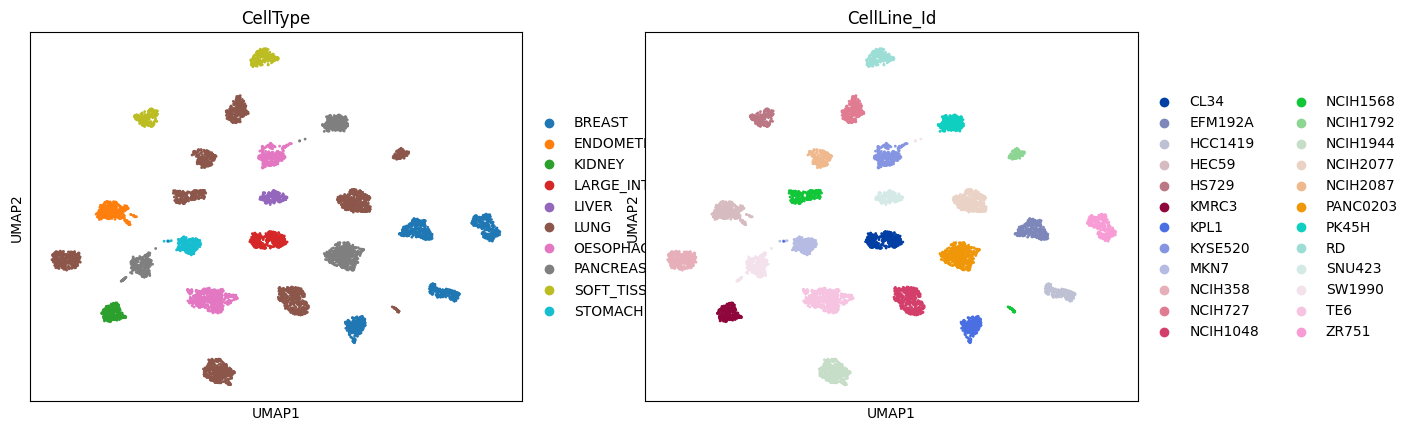

In [140]:
# Make a subset of the adata by filtering for the cell lines specified in the Kinker paper. (see above lines of code )
# Plot and color by CellLine_Id
sc.pl.umap(subset_adata, color=['CellType','CellLine_Id'])

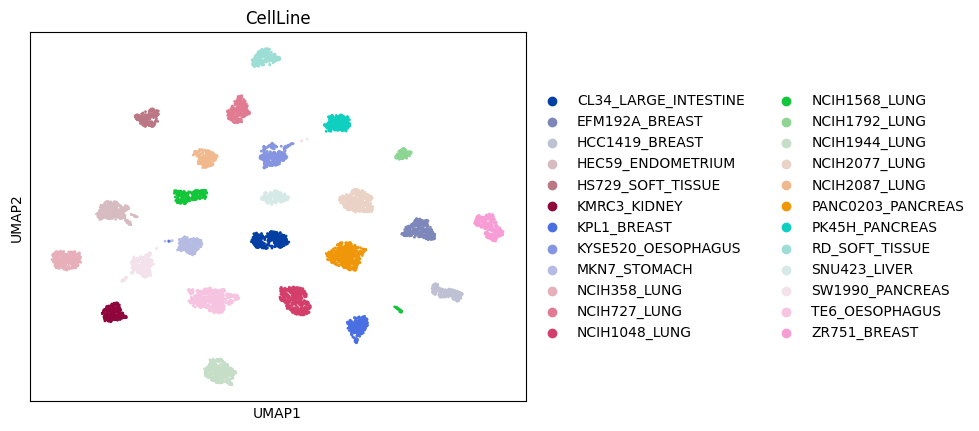

In [141]:
sc.pl.umap(subset_adata, color=['CellLine'])

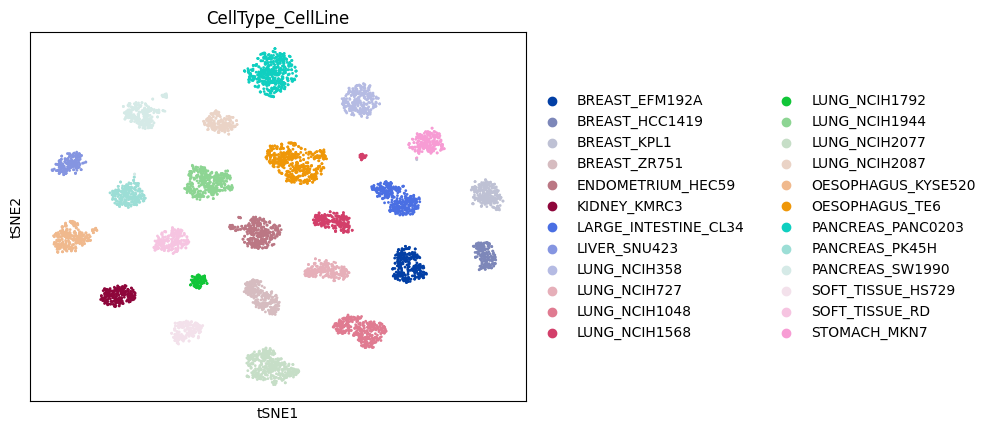

In [144]:
# try to replicate using t-SNE:
# Ensure the DataFrame has the combined column
subset_adata.obs['CellType_CellLine'] = (
    subset_adata.obs['CellType'].astype(str) + '_' + subset_adata.obs['CellLine_Id'].astype(str)
)

sc.pl.tsne(subset_adata, color=['CellType_CellLine'], show=True)

This almost looks similar to the Kinker Fig 1b.  However, the colors are not gradient for each Cell type. 
The better way is to try to color by CellType and gradient is by CellLine_Id. However, after several tries with Google, ChatGPT help to create custom color mapping, the plot still does not map the colors correctly.

I'm pretty happy with the plot above as the re-ordered CellType_CellLine makes it easier to look by cell type.

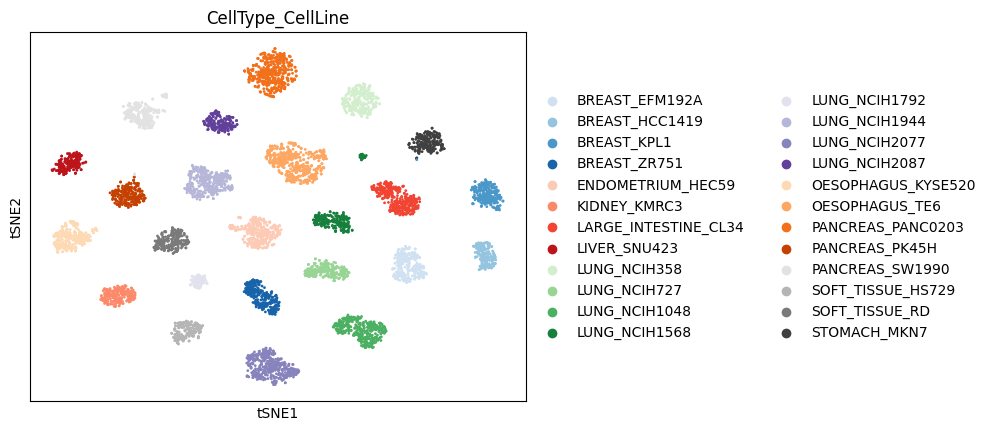

In [145]:
# One more try to change the palette to 4 colors of blues, then 4 colors of reds, 4 greens, etc to better match cell type.

import seaborn as sns

# Define your custom palette
custom_palette = sns.color_palette("Blues", 4) + \
                 sns.color_palette("Reds", 4) + \
                 sns.color_palette("Greens", 4) + \
                 sns.color_palette("Purples", 4) + \
                 sns.color_palette("Oranges", 4) + \
                 sns.color_palette("Greys", 4)

# Convert 'CellType_CellLine' to a standard Series if necessary
# subset_adata.obs['CellType_CellLine'] = subset_adata.obs['CellType_CellLine'].astype(str)

# Assign colors to CellType_CellLine
unique_labels = subset_adata.obs['CellType_CellLine'].unique()
color_mapping = dict(zip(unique_labels, custom_palette))

# Ensure 'CellType_CellLine' is string and apply the mapping again
subset_adata.obs['CellType_CellLine'] = subset_adata.obs['CellType_CellLine'].astype(str)
subset_adata.obs['CellType_CellLine_Color'] = subset_adata.obs['CellType_CellLine'].map(color_mapping).astype(str)

# Ensure there are no NaN values.  NaN are plotted with transparent.
subset_adata.obs['CellType_CellLine_Color'] = subset_adata.obs['CellType_CellLine_Color'].fillna('transparent')

# Try plotting again, potentially without sorting, with default palette
sc.pl.tsne(subset_adata, color='CellType_CellLine', palette=custom_palette, show=True)


## Challenge ##

**Try to reproduce Figure 2B and 2D from Kinker et al.**


I did not spend a lot of time on this.  After plotting really quickly with existing adata dataframe, I realized that to replicate these plots, I will need to do better assessments of the discrete_cluster_minpts5_eps1.8 vs the DBSCAN results.  

I will go back to the code at https://github.com/gabrielakinker/CCLE_heterogeneity to learn more on how to properly generate these plots.


In [319]:
# Try to reprocess tsne with different perplexity:
adata = sc.read_h5ad(cwd+'/outs/AY_240828_kinker_anndata.h5ad')

# Split 'CellLine' into two parts
adata.obs[['CellLine_Id', 'CellType']] = adata.obs['CellLine'].str.split('_', n=1, expand=True)

adata = BasicScanpyPreprocessing(adata, n_top_genes=2000, n_neighbors=20, n_pcs=50, random_state=20)

In [265]:
# Figure 2b: t-SNE plots showing exemplary cell lines for the 4 classes defined by the presence and 
  # number of discrete subpopulations that were identified using DBSCAN.
# The description of each class and number of cell lines is indicated above the t-SNE plots.


# t-SNE plots: 
#  NCIH2110 (>2 clusters (n=3))
#  NCIH1299 (2 major clusters (n=3))
#  CAK12 (Major & minor clusters (n=16))
#  JHU006 (1 cluster (n=176))

fig2b_list = ['NCIH2110']

# subset to only the above celllines:
ncih2110_adata = adata[adata.obs['CellLine_Id'].isin(fig2b_list), :]

# print(ncih2110_adata.obs.head())


/Users/weihsienyang/Library/Python/3.9/lib/python/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/weihsienyang/Library/Python/3.9/lib/python/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


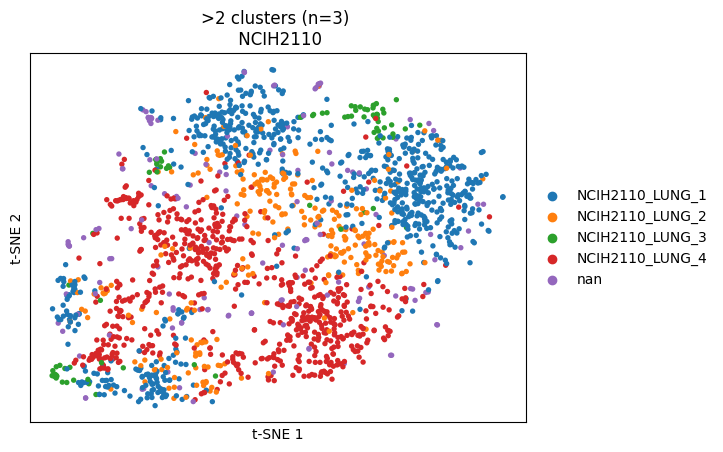

In [266]:
# filtered_ncif2110 = ncih2110_adata[~ncih2110_adata.obs['CNA_subclone'].isna()]

#  NCIH2110 (>2 clusters (n=3))
sc.pl.tsne(ncih2110_adata[~ncih2110_adata.obs['Discrete_cluster_minpts5_eps1.8'].isna()], 
           color='Discrete_cluster_minpts5_eps1.8', 
           title='>2 clusters (n=3) \n NCIH2110',
           show=False)

# Add axis titles
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')

# Display plot
plt.show()


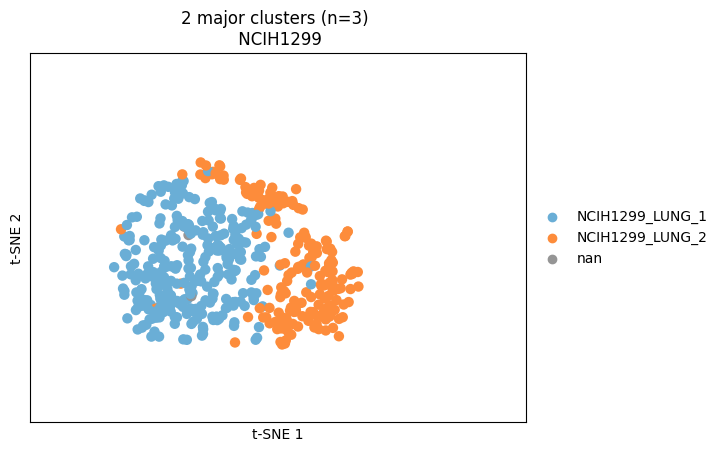

In [307]:

# try to plot all 4 examples using matplotlib
# t-SNE plots: 
#  NCIH2110 (>2 clusters (n=3))
#  NCIH1299 (2 major clusters (n=3))
#  CAK12 (Major & minor clusters (n=16))
#  JHU006 (1 cluster (n=176))

fig2b_list = ['NCIH1299']

# subset to only the above celllines:
fig2b_adata = adata[adata.obs['CellLine_Id'].isin(fig2b_list)].copy()

# print(fig2b_adata.obs.head())

# Define palette:
custom_palette = sns.color_palette("Blues", 1) + \
                 sns.color_palette("Oranges", 1) + \
                 sns.color_palette("Greys", 1)


# Assign colors to CellType_CellLine
unique_labels = fig2b_adata.obs['Discrete_cluster_minpts5_eps1.8'].unique()
color_mapping = dict(zip(unique_labels, custom_palette))

# Ensure 'CellType_CellLine' is string and apply the mapping again
fig2b_adata.obs['Discrete_cluster_minpts5_eps1.8'] = fig2b_adata.obs['Discrete_cluster_minpts5_eps1.8'].astype(str)
fig2b_adata.obs['Discrete_cluster_Color'] = fig2b_adata.obs['Discrete_cluster_minpts5_eps1.8'].map(color_mapping).astype(str)

#  NCIH1299 (2 major clusters (n=3))
sc.pl.tsne(fig2b_adata,
           color='Discrete_cluster_minpts5_eps1.8', 
           palette=custom_palette,
           title='2 major clusters (n=3) \n NCIH1299',
           show=False)

# Add axis titles
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')

# Zoom into the plot to show better resolution of the center
plt.xlim(40,60)  # Adjust these limits based on your data
plt.ylim(-40,-20)  # Adjust these limits based on your data

# Display plot
plt.show()

In [282]:
#  CAK12 (Major & minor clusters (n=16))
#  JHU006 (1 cluster (n=176))
fig2b_list = ['CAK12']

# subset to only the above celllines:
fig2b_adata = adata[adata.obs['CellLine_Id'].isin(fig2b_list)].copy()

print(f"Number of entries in fig2b_adata: {fig2b_adata.shape[0]}")

#  CAK12 Major & minor clusters:
# sc.pl.tsne(fig2b_adata,
  #         color='Discrete_cluster_minpts5_eps1.8', 
   #        title='Major & minor clusters (n=16) \n CAK12',
    #       show=False)

# Add axis titles
# plt.xlabel('t-SNE 1')
# plt.ylabel('t-SNE 2')

# Zoom into the plot to show better resolution of the center
# plt.xlim(40,55)  # Adjust these limits based on your data
# plt.ylim(-40,-20)  # Adjust these limits based on your data

# Display plot
# plt.show()

Number of entries in fig2b_adata: 0


I checked both the metadata file and the adata files.  None of which contain CellLine with "CAK12" in the name.

Number of entries in fig2b_adata: 325


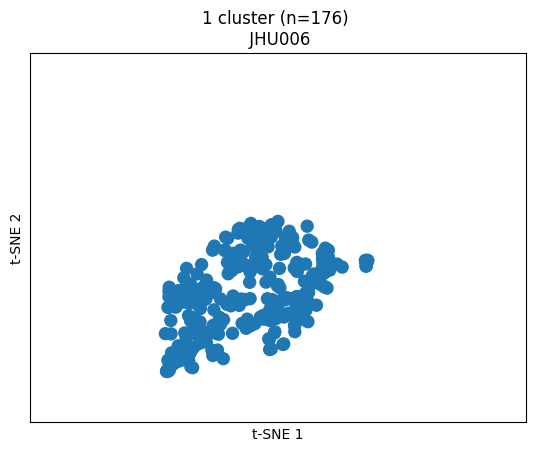

In [311]:
#  JHU006 (1 cluster (n=176))
fig2b_list = ['JHU006']

# subset to only the above celllines:
fig2b_adata = adata[adata.obs['CellLine_Id'].isin(fig2b_list)].copy()

print(f"Number of entries in fig2b_adata: {fig2b_adata.shape[0]}")
# print(fig2b_adata.obs.head(10))

#  JHU006 1 cluster:
sc.pl.tsne(fig2b_adata,
           color='Discrete_cluster_minpts5_eps1.8', 
           title='1 cluster (n=176) \n JHU006',
           show=False)

# Remove the legend
plt.gca().get_legend().remove()

# Add axis titles
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')

# Zoom into the plot to show better resolution of the center
plt.xlim(-90,-70)  # Adjust these limits based on your data
plt.ylim(60,80)  # Adjust these limits based on your data

# Display plot
plt.show()

In [313]:
# Fig 2d: plot JHU006 heatmap of gene expression (log2) by Cell cycle G1/S, G2/M, pEMT, and Episen

# print(fig2b_adata.obs.tail(10))


                               CellLine    Pool            Indication  \
c4660  JHU006_UPPER_AERODIGESTIVE_TRACT  custom  Head and Neck Cancer   
c4666  JHU006_UPPER_AERODIGESTIVE_TRACT  custom  Head and Neck Cancer   
c4691  JHU006_UPPER_AERODIGESTIVE_TRACT  custom  Head and Neck Cancer   
c4708  JHU006_UPPER_AERODIGESTIVE_TRACT  custom  Head and Neck Cancer   
c4714  JHU006_UPPER_AERODIGESTIVE_TRACT  custom  Head and Neck Cancer   
c4722  JHU006_UPPER_AERODIGESTIVE_TRACT  custom  Head and Neck Cancer   
c4724  JHU006_UPPER_AERODIGESTIVE_TRACT  custom  Head and Neck Cancer   
c4731  JHU006_UPPER_AERODIGESTIVE_TRACT  custom  Head and Neck Cancer   
c4735  JHU006_UPPER_AERODIGESTIVE_TRACT  custom  Head and Neck Cancer   
c4741  JHU006_UPPER_AERODIGESTIVE_TRACT  custom  Head and Neck Cancer   

       Genes_expressed Discrete_cluster_minpts5_eps1.8  \
c4660             4623                             nan   
c4666             5101                             nan   
c4691             3252

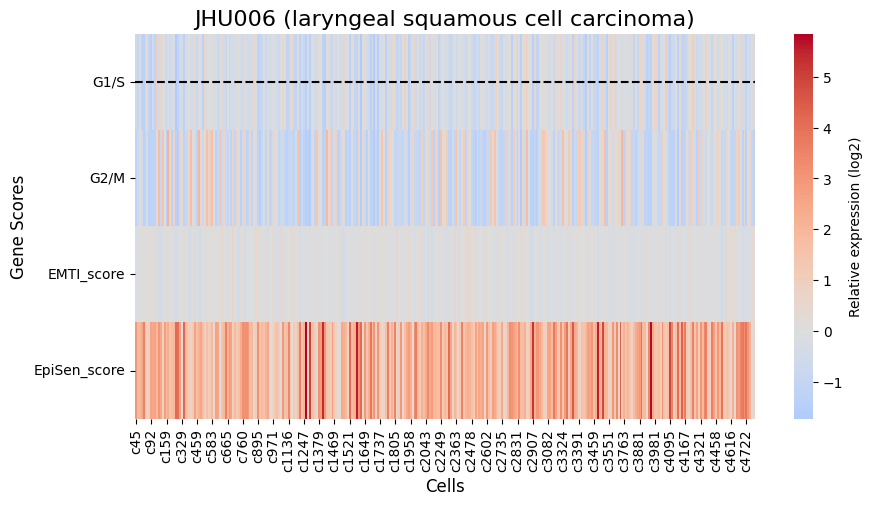

In [318]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


# use fig2b_adata
 
# Restructure the DataFrame (ensure genes are rows and cells are columns)
expression_data = fig2b_adata.obs[['G1/S_score', 'G2/M_score', 'EMTI_score', 'EpiSen_score']].T 
expression_data.index = ['G1/S', 'G2/M', 'EMTI_score', 'EpiSen_score']  # Set indices for better labeling

# Set up the matplotlib figure
plt.figure(figsize=(10, 5))

# Generate the heatmap
sns.heatmap(expression_data, cmap='coolwarm', center=0, cbar_kws={"label": "Relative expression (log2)"})

# Add annotations and formatting
plt.title('JHU006 (laryngeal squamous cell carcinoma)', fontsize=16)
plt.xlabel('Cells', fontsize=12)
plt.ylabel('Gene Scores', fontsize=12)

# Add horizontal lines to separate groups
plt.axhline(y=0.5, color='k', linestyle='--')  # Example line; adjust as needed

# Adjust y-ticks for clarity
plt.yticks(rotation=0)

# Show the plot
plt.show()